# PSF Gaussian Fitting demo

This notebook demonstrates PSF fitting to a 2-D gaussian beam. The fitting code was adopted from https://github.com/casangi/cngi_prototype/blob/master/cngi/image/fit_gaussian.py . This demo uses a CASA PSF image and converted into an XRadio image format, then fitting is performed. Simple numerical comparison with the beam parameters stored in the input CASA image are also made.

### Data setup

In [1]:
# use toolviper
import toolviper
toolviper.utils.data.update()


[2025-09-12 15:56:14,132]  WARNING    viperlog:  File exists: /Users/ttsutsum/miniforge3/envs/py312_env/lib/python3.12/site-packages/toolviper/utils/data/.cloudflare 
[2025-09-12 15:56:14,132]     INFO    viperlog:  Updating file metadata information ...  


Output()

In [2]:
from toolviper.utils.data import download
download(file="twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf")

[2025-09-12 15:56:14,536]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List                                      
 ─────────────────────────────────────────────────── 
  twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf

[2025-09-12 15:56:14,541]     INFO    viperlog:  File exists: twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf 


Output()

Load a CASA psf image into an XRADIO image data

In [3]:
from xradio.image import read_image
xds = read_image(infile='twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf', chunks={"l":25, "m":25, "frequency":4} )

[2025-09-12 15:56:16,872]     INFO    viperlog:  J2000 found as system reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 
Successful readonly open of default-locked table twhya_selfcal_11chans_lsrk_robust_0.5_niter_0.psf: 1 columns, 1 rows
[2025-09-12 15:56:16,876]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


In [4]:
xds.BEAM

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

Run gaussian fit on the psf in xradio image format

In [5]:
from astroviper.core.image_analysis.psf_gaussian_fit import psf_gaussian_fit
psf_gaussian_fit?

Signature:
psf_gaussian_fit(
    xds: xarray.core.dataset.Dataset,
    dv: str = 'SKY',
    npix_window: tuple = [9, 9],
    sampling: tuple = [9, 9],
    cutoff: float = 0.35,
)
Docstring:
fit 2D gaussian to psf

Parameters
----------
xds : xarray.Dataset
    The input data cube.
dv : str
    The data variable to fit. Default is 'SKY'.
npix_window : list
    The size of the fitting window in pixels.
sampling : list
    The sampling of the fitting grid in pixels.
cutoff : float
    The cutoff value for the fitting.

Returns
-------
xds : xarray.Dataset
    The image with the fitted parameters added.
    The unit of beam size (major and minor) will be the same unit as
    that of the input image's (l,m) coordintes, which assumed to be
    radian. The position angle is given in degrees.
File:      ~/SWDevel/radps/viper/sandbox/astroviper/src/astroviper/core/image_analysis/psf_gaussian_fit.py
Type:      function

In [6]:
res_xds = psf_gaussian_fit(xds,npix_window=(21,21), sampling=(21,21))

/Users/ttsutsum/SWDevel/radps/viper/sandbox/astroviper/src/astroviper/core/image_analysis/psf_gaussian_fit.py:178: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
  with objmode(res_x="f8[:]"):  # return type annotation


In [7]:
res_xds.BEAM

<xarray.DataArray 'BEAM' (time: 1, frequency: 11, polarization: 1, beam_param: 3)> Size: 264B
dask.array<array, shape=(1, 11, 1, 3), dtype=float64, chunksize=(1, 11, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 8B 5.625e+04
  * frequency     (frequency) float64 88B 3.728e+11 3.728e+11 ... 3.728e+11
  * polarization  (polarization) <U1 4B 'I'
    velocity      (frequency) float64 88B 2.454e+03 1.964e+03 ... -2.454e+03
  * beam_param    (beam_param) <U5 60B 'major' 'minor' 'pa'
Attributes:
    units:    rad

In [8]:
data_sel = {'time':[0], 'polarization':[0], 'frequency':[0]}

bmaj=2.6214203167700385e-06,bmin=2.1205892648113387e-06, bpa=30.86190414428711


'rad'

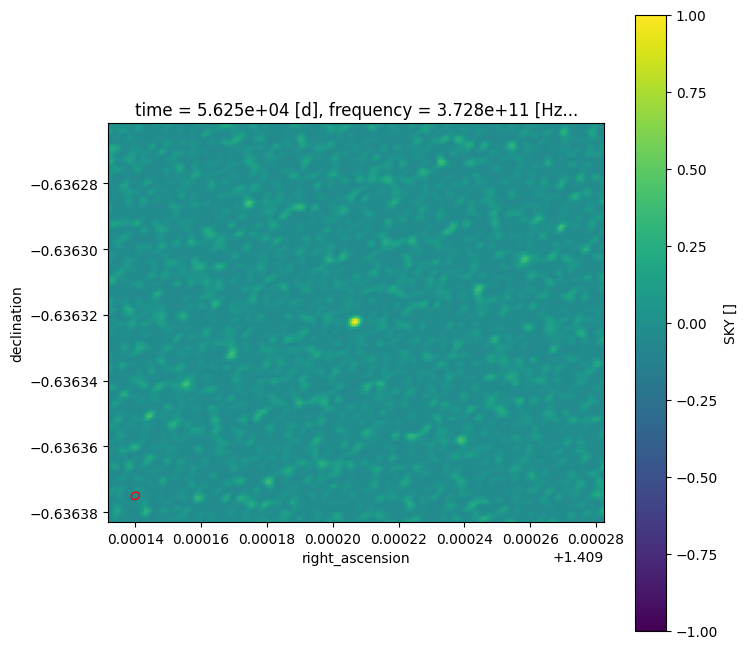

In [9]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

data1 = xds.SKY.isel(data_sel).squeeze().T
#
fig, ax = plt.subplots(figsize=(8,8))
data1.plot.pcolormesh(x='right_ascension', y='declination', ax=ax, cmap='viridis', add_colorbar=True)
bmaj = xds.BEAM.isel(data_sel).data.compute()[0,0,0][0]
bmin = xds.BEAM.isel(data_sel).data.compute()[0,0,0][1]
bpa = np.rad2deg(xds.BEAM.isel(data_sel).data.compute()[0,0,0][2])
print(f'bmaj={bmaj},bmin={bmin}, bpa={bpa}')
from matplotlib.patches import Ellipse

beam = Ellipse(
    (1.40914,-0.636375),
    width=bmaj,
    height=bmin,
    angle=bpa,
    color='red',
    lw=1,
    fill=False,
    zorder=10 # Ensure the ellipse is drawn on top
)
ax.add_patch(beam)
ax.set_aspect('equal', adjustable='box')
xds.BEAM.attrs['units']

In [10]:
from xradio.image import write_image

In [11]:
write_image(res_xds, "fitted_beam.im", out_format="casa",overwrite=True)

[2025-09-12 15:56:28,207]  WARNING    viperlog:  Because overwrite=True, removing existing path fitted_beam.im 


### Compare the fitting result with one provided in the input image

In [12]:
# Generate 2D gaussian based on the beam parameters
def psf_model(xds, data_sel, beam_param):
    wx, wy, rot = beam_param
    print(f"bmaj:{wx}, bmin:{wy}, pa:{rot}")
    l = xds.SKY.isel(data_sel).l.data
    m = xds.SKY.isel(data_sel).m.data
    X, Y = np.meshgrid(l,m)
    # rotation angle measured from +x axis
    rot = -(np.pi/2 - rot)
    print('rot=',rot)
    xp = X*np.cos(rot) + Y*np.sin(rot)
    yp = X*np.sin(rot) - Y*np.cos(rot)
    gaussian = 1.0 * np.exp(-(((xp) / wx) ** 2 + ((yp) / wy) ** 2) / 2.0)
    return gaussian

In [13]:
model = psf_model(xds, data_sel,res_xds.BEAM.isel(data_sel).data.compute().squeeze())

bmaj:2.620849775164605e-06, bmin:2.1317423842925252e-06, pa:0.5580182844932495
rot= -1.012778042301647


In [14]:
casa_model = psf_model(xds, data_sel, xds.BEAM.isel(data_sel).data.compute().squeeze())

bmaj:2.6214203167700385e-06, bmin:2.1205892648113387e-06, pa:0.5386418407526932
rot= -1.0321544860422034


In [15]:
beam_param = res_xds.BEAM.data.compute()
bmajs = beam_param[:,:,:].squeeze().T[0]
bmins = beam_param[:,:,:].squeeze().T[1]
pas = beam_param[:,:,:].squeeze().T[2]
casa_beam_param = xds.BEAM.data.compute()
casa_bmajs = casa_beam_param[:,:,:].squeeze().T[0]
casa_bmins = casa_beam_param[:,:,:].squeeze().T[1]
casa_pas = casa_beam_param[:,:,:].squeeze().T[2]

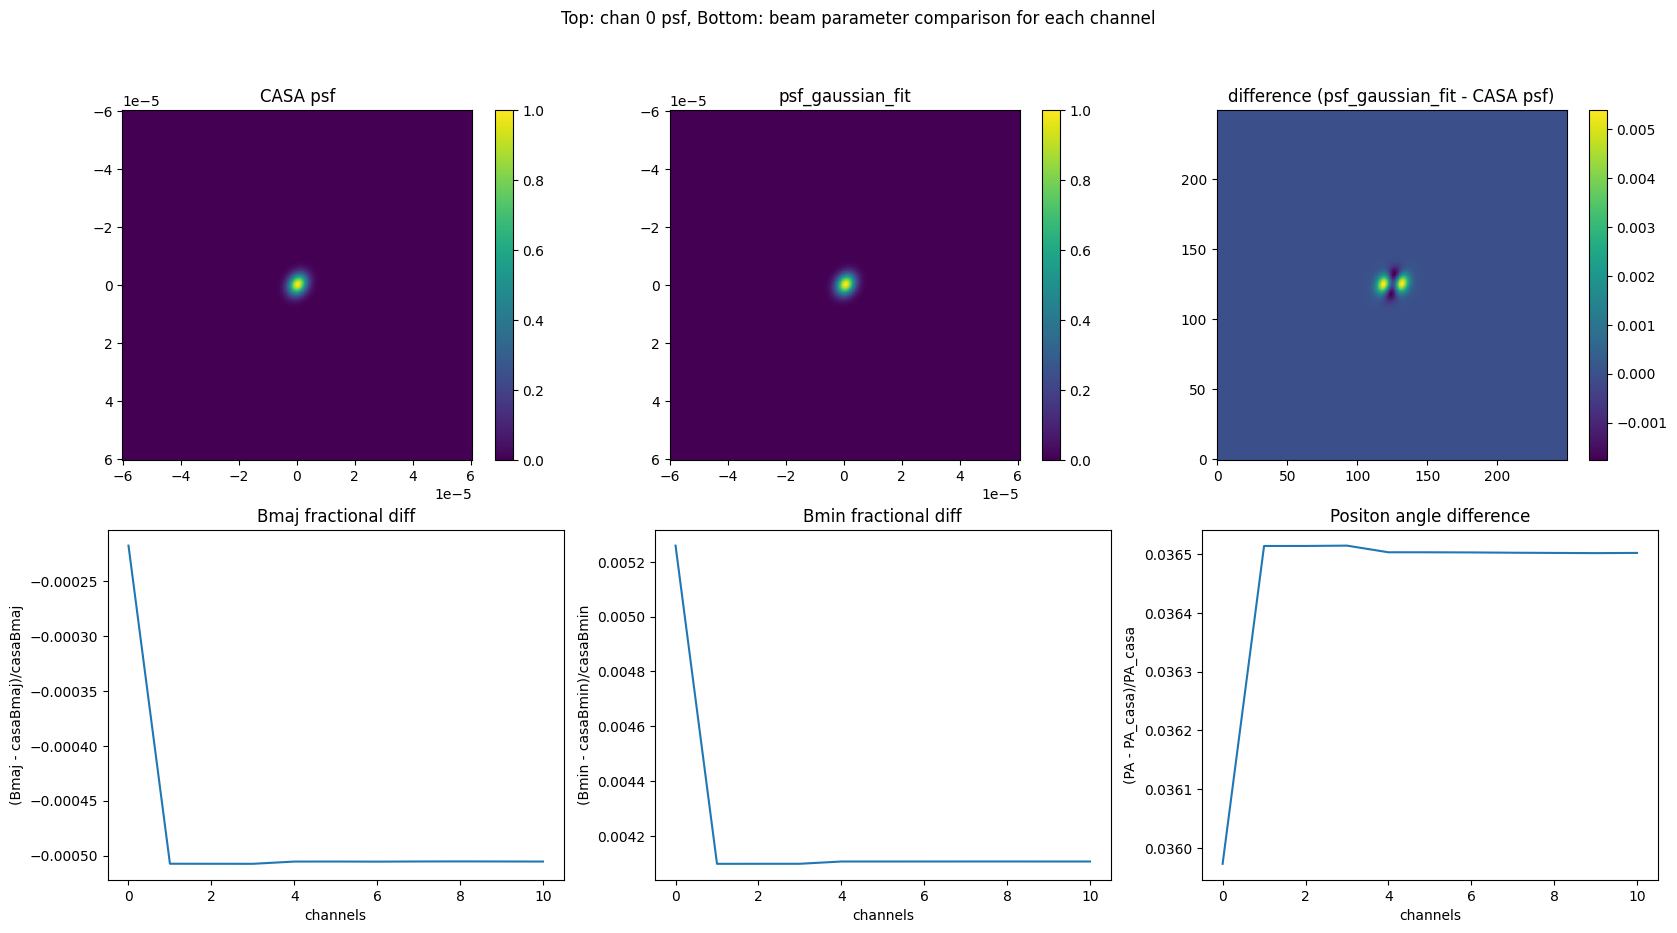

In [16]:


fig, axes = plt.subplots(2, 3, figsize=(20, 10))
l = xds.SKY.isel(data_sel).l.data
m = xds.SKY.isel(data_sel).m.data
extent=(l[-1], l[0], m[-1], m[0])
im1 = axes[0, 0].imshow(casa_model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im1, ax=axes[0,0])
axes[0, 0].set_title("CASA psf")
im2 = axes[0, 1].imshow(model, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(im2, ax=axes[0,1])
axes[0,1].set_title("psf_gaussian_fit")
im3 = axes[0,2].imshow( (model - casa_model), origin='lower', cmap='viridis')
axes[0,2].set_title("difference (psf_gaussian_fit - CASA psf)")
plt.colorbar(im3, ax=axes[0,2])
#im_data = xds.SKY.isel(data_sel).data.compute().squeeze()#
#X, Y = np.meshgrid(l,m)
#x_cen = int(len(l)/2)
#y_cen = int(len(m)/2)
chans = np.arange(beam_param.shape[1])
axes[1,0].plot(chans, (bmajs - casa_bmajs)/bmaj)
axes[1,0].set_ylabel("(Bmaj - casaBmaj)/casaBmaj")
axes[1,0].set_xlabel("channels")
axes[1,0].set_title("Bmaj fractional diff")
axes[1,1].plot(chans, (bmins - casa_bmins)/casa_bmins)
axes[1,1].set_ylabel("(Bmin - casaBmin)/casaBmin")
axes[1,1].set_xlabel("channels")
axes[1,1].set_title("Bmin fractional diff")
#axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
axes[1,2].set_ylabel("(PA - PA_casa)/PA_casa")
axes[1,2].set_xlabel("channels")
axes[1,2].set_title("Positon angle difference")
axes[1,2].plot(chans, (pas - casa_pas)/casa_pas)
fig.suptitle("Top: chan 0 psf, Bottom: beam parameter comparison for each channel")
plt.show()